# Simple machine learning
Let us explore some of the simplest machine learning methods. We will explore principal component analysis (PCA) and k-means. They are not based on neural networks but they are still of very much use in science.

Let us first start by importing some packages. We will carry out PCA by hand and k-means using `scikit-learn`. However, you can do both using the package.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import h5py
from sklearn.cluster import KMeans

We have an HDF5 file that contains observations of a quiet Sun field of view with Hinode. We will only use the intensity profiles but what I show here can be applied to the rest of Stokes profiles or to other observations.

In [2]:
f = h5py.File('quiet.h5', 'r')
stokes = f['stokesI'][:]
f.close()

We also read the wavelength axis of the Hinode SP.

In [3]:
wvl = np.loadtxt('wavelengthHinode.txt')
print(wvl)

[6300.8921 6300.9136 6300.9351 6300.9561 6300.9775 6300.999  6301.0205
 6301.042  6301.0635 6301.0845 6301.106  6301.1274 6301.1489 6301.1704
 6301.1914 6301.2129 6301.2344 6301.2559 6301.2773 6301.2988 6301.3198
 6301.3413 6301.3628 6301.3843 6301.4058 6301.4268 6301.4482 6301.4697
 6301.4912 6301.5127 6301.5342 6301.5552 6301.5767 6301.5981 6301.6196
 6301.6411 6301.6621 6301.6836 6301.7051 6301.7266 6301.748  6301.7695
 6301.7905 6301.812  6301.8335 6301.855  6301.8765 6301.8975 6301.9189
 6301.9404 6301.9619 6301.9834 6302.0049 6302.0259 6302.0474 6302.0688
 6302.0903 6302.1118 6302.1328 6302.1543 6302.1758 6302.1973 6302.2188
 6302.2402 6302.2612 6302.2827 6302.3042 6302.3257 6302.3472 6302.3682
 6302.3896 6302.4111 6302.4326 6302.4541 6302.4751 6302.4966 6302.5181
 6302.5396 6302.561  6302.5825 6302.6035 6302.625  6302.6465 6302.668
 6302.6895 6302.7104 6302.7319 6302.7534 6302.7749 6302.7964 6302.8179
 6302.8389 6302.8604 6302.8818 6302.9033 6302.9248 6302.9458 6302.9673
 6302.9

Let us compute the average continuum intensity and normalize all data to this value.

In [4]:
cont = np.mean(stokes[:, :, 0])
stokes /= cont
nx, ny, nl = stokes.shape

Now we show the field of view. On the left, a wavelength in the continuum. On the right, a wavelength close to the core of the 6301.5 A line. You can see the difference in appearance because the two wavelengths are sampling different heights in the atmosphere.

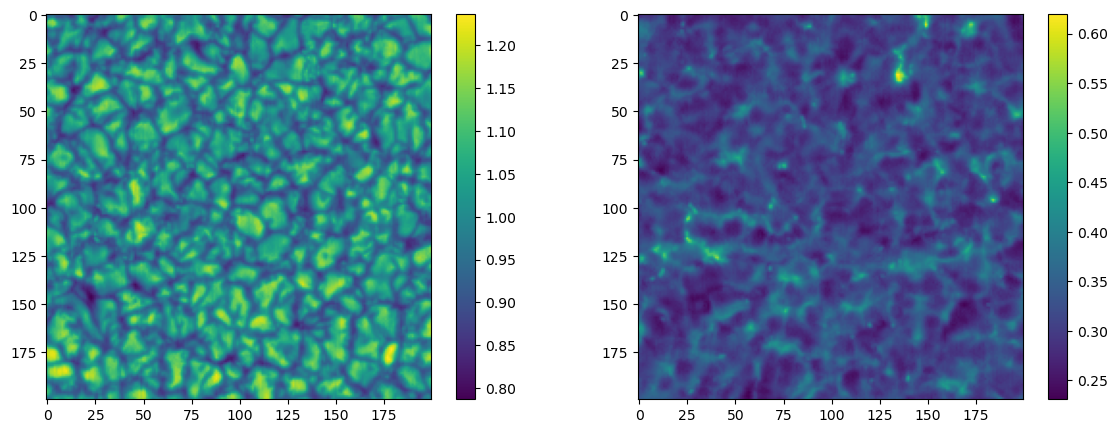

In [5]:
fig, ax = pl.subplots(nrows=1, ncols=2, figsize=(14,5))
im = ax[0].imshow(stokes[:, :, 0])
pl.colorbar(im, ax=ax[0])
im = ax[1].imshow(stokes[:, :, 29])
pl.colorbar(im, ax=ax[1])

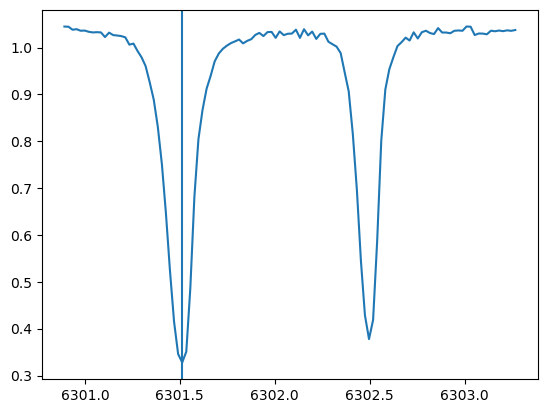

In [6]:
fig, ax = pl.subplots()
ax.plot(wvl, stokes[75, 75, :])
ax.axvline(wvl[29])

## PCA
The PCA technique tries to find a linear transformation of the data onto a new coordinate system such that the directions (principal components) capturing the largest variation in the data can be easily identified. The PCA decomposition can be obtained by doing the singular value decomposition of the $S \times M$ data matrix, with $S$ being the length of each observation and $M$ the number of observations. A more efficient way of doing it is computing the correlation matrix of smallest dimension (among $S \times S$ and $M \times M$) and doing the SVD of this matrix. The eigenfunctions will be the same while the eigenvalues will be those of the original matrix squared.

In [7]:
mat = stokes.reshape((nx*ny, nl))
cov = mat.T @ mat
U, S, Vh = np.linalg.svd(cov)

Let's draw some eigenfunctions:

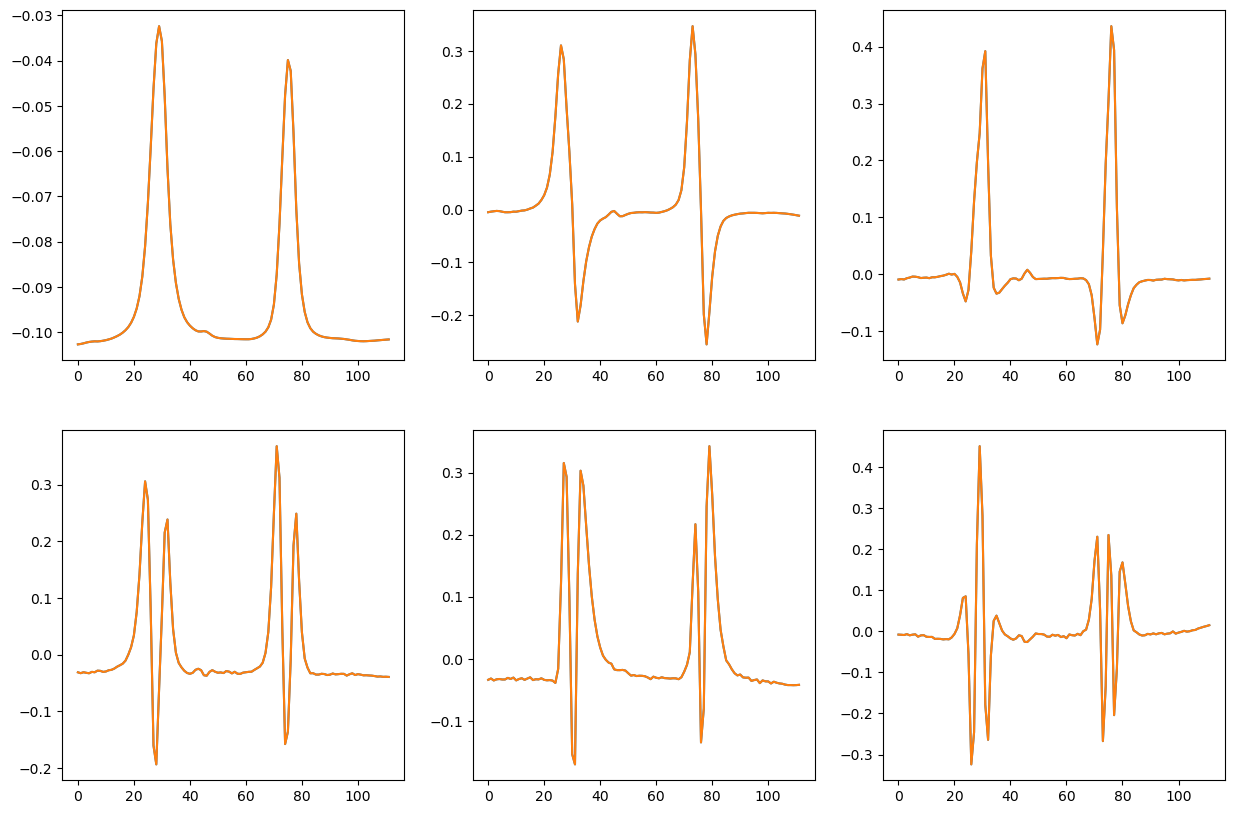

In [8]:
fig, ax = pl.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i in range(6):
    ax.flat[i].plot(Vh[i, :])
    ax.flat[i].plot(U[:, i])

The first eigenvector is roughly equal to the average profile because we did not substract the mean. The following ones are roughly similar to derivatives of higher order of the profiles. Rough estimation of velocities can be computed by simply showing (calibrated) maps of the projection over the second eigenvector.

(40000, 112)


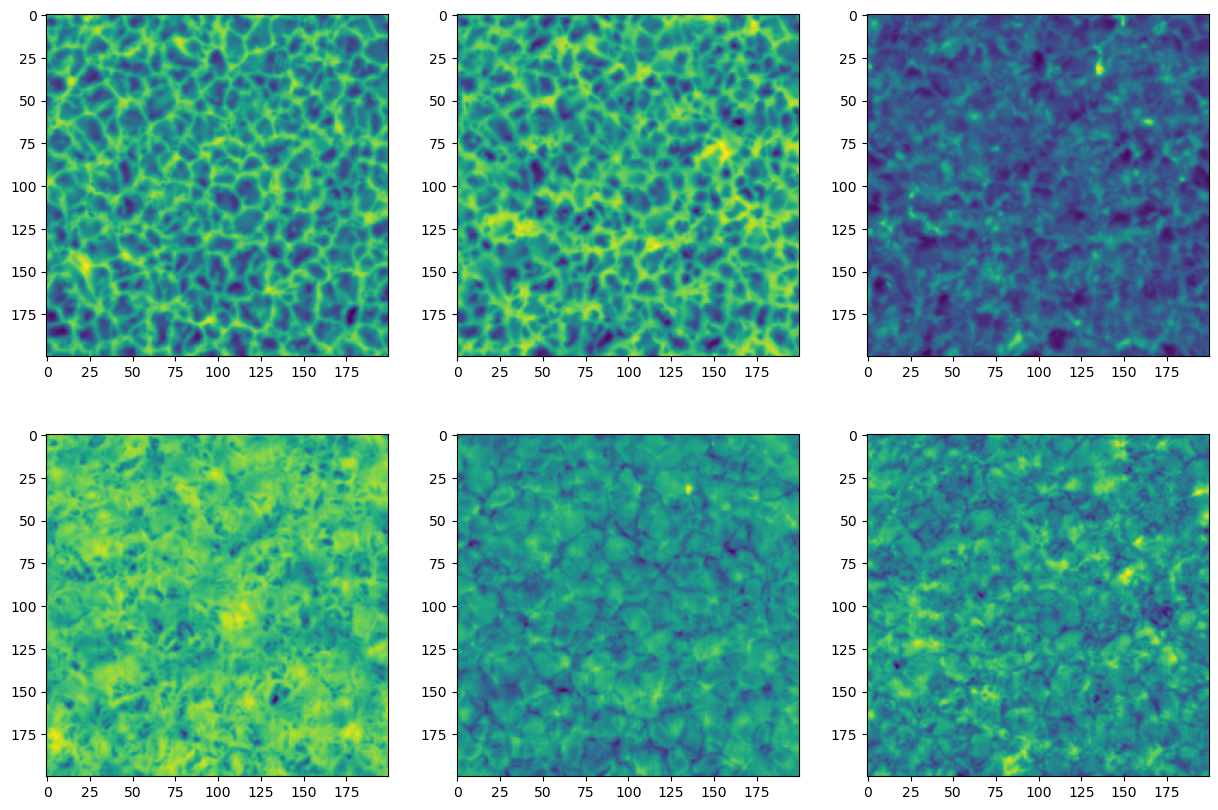

In [9]:
coef = mat @ Vh.T
print(coef.shape)

fig, ax = pl.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i in range(6):
    ax.flat[i].imshow(coef[:, i].reshape((nx, ny)))

### Denoising
One of the most straightforward uses of PCA is denoising. For this purpose, we clamp the eigenbasis using only $K$ eigenvectors and reconstruct back the profiles. Since PCA orders eigenvectors by the amount of variance explained by them, the final eigenvectors are simply used to explain noise.

(200, 200, 112)


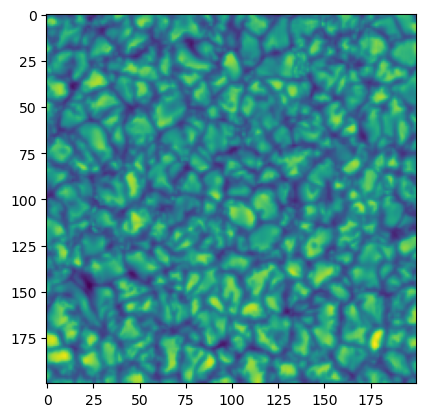

In [10]:
npca = 5
Vh_crop = Vh[0:npca, :]
coef = mat @ Vh_crop.T
reconstructed = coef @ Vh_crop
reconstructed = reconstructed.reshape((nx, ny, nl))
print(reconstructed.shape)
pl.imshow(reconstructed[:, :, 0])

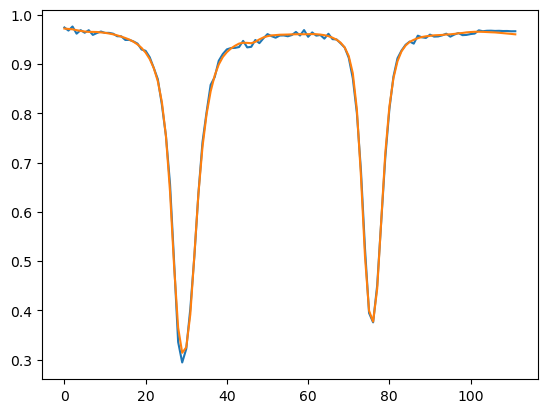

In [11]:
pl.plot(stokes[100, 100, :])
pl.plot(reconstructed[100, 100, :])

## k-means
k-means is an unsupervised clustering/classification method that is often used in Solar Physics. The aim is partition $n$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

Let us use `scikit-learn` to carry out the experiments. We cluster the previous observations into 2, 3 and 5 clusters.

In [12]:
kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans3 = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans5 = KMeans(n_clusters=5, random_state=0, n_init="auto")

In [13]:
kmeans2.fit(mat)
kmeans3.fit(mat)
kmeans5.fit(mat)

KMeans(n_clusters=5, random_state=0)

Text(0.5, 1.0, 'k-means 5 classes')

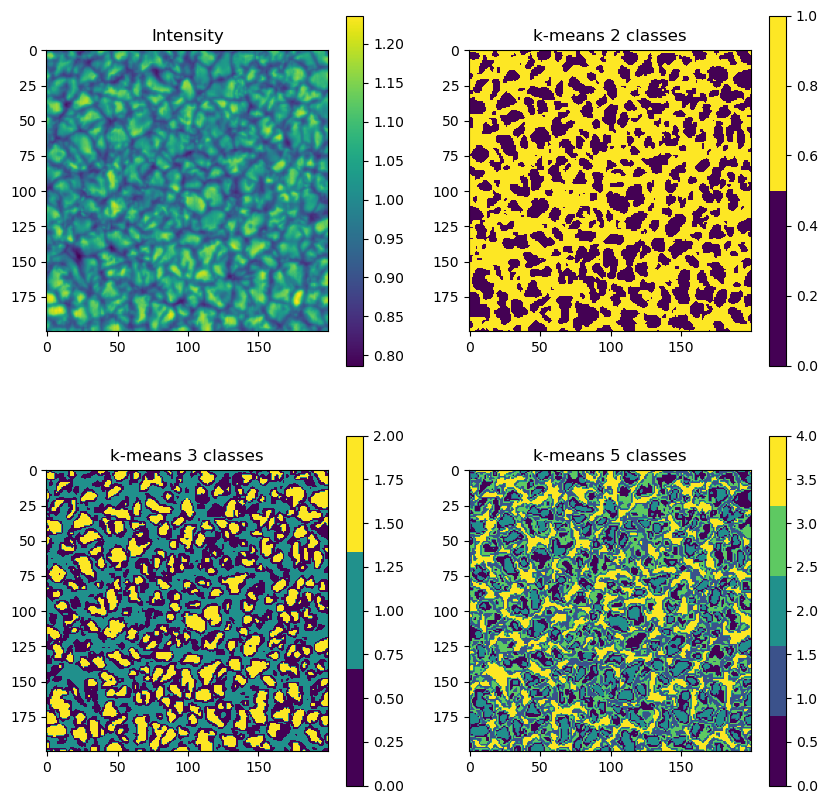

In [14]:
labels2 = kmeans2.labels_.reshape((nx, ny))
labels3 = kmeans3.labels_.reshape((nx, ny))
labels5 = kmeans5.labels_.reshape((nx, ny))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10, 10))
im = ax[0, 0].imshow(stokes[:, :, 0])
pl.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title('Intensity')
im = ax[0, 1].imshow(labels2, cmap=mpl.colormaps['viridis'].resampled(2))
pl.colorbar(im, ax=ax[0, 1])
ax[0, 1].set_title('k-means 2 classes')
im = ax[1, 0].imshow(labels3, cmap=mpl.colormaps['viridis'].resampled(3))
pl.colorbar(im, ax=ax[1, 0])
ax[1, 0].set_title('k-means 3 classes')
im = ax[1, 1].imshow(labels5, cmap=mpl.colormaps['viridis'].resampled(5))
pl.colorbar(im, ax=ax[1, 1])
ax[1, 1].set_title('k-means 5 classes')

We show now the representative profiles of the cluster centers:

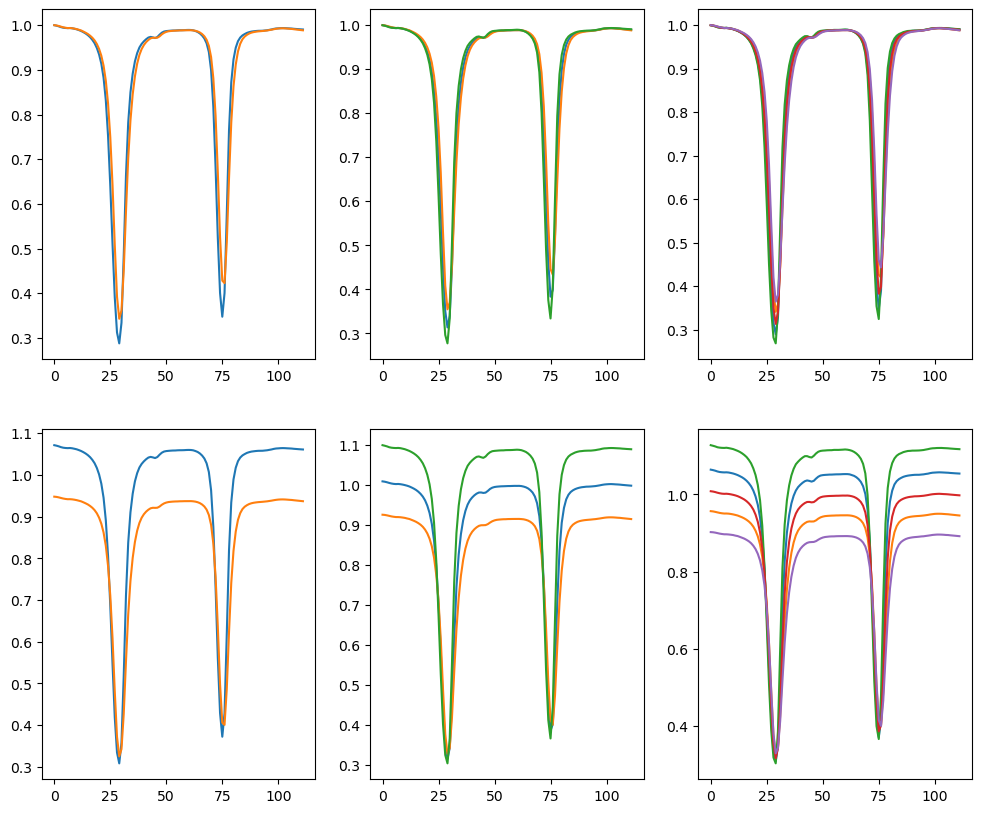

In [16]:
fig, ax = pl.subplots(nrows=2, ncols=3, figsize=(12, 10))
for i in range(2):
    ax[0, 0].plot(kmeans2.cluster_centers_[i, :] / kmeans2.cluster_centers_[i, 0])
    ax[1, 0].plot(kmeans2.cluster_centers_[i, :])
for i in range(3):
    ax[0, 1].plot(kmeans3.cluster_centers_[i, :] / kmeans3.cluster_centers_[i, 0])
    ax[1, 1].plot(kmeans3.cluster_centers_[i, :])
for i in range(5):
    ax[0, 2].plot(kmeans5.cluster_centers_[i, :] / kmeans5.cluster_centers_[i, 0])
    ax[1, 2].plot(kmeans5.cluster_centers_[i, :])